# Task 2: Time Series Forecasting Models
Overview
Now that we understand our data, we'll build models to predict future stock prices. We'll create two different types of models:

ARIMA: A traditional statistical model that's interpretable and reliable
LSTM: A deep learning model that can capture complex patterns

These predictions will help us make informed decisions about portfolio allocation.
Why We Need Forecasting Models
In portfolio management, predicting future price movements (even with uncertainty) helps us:

Decide when to buy or sell assets
Determine optimal portfolio weights
Assess potential risks and returns
Make data-driven investment decisions

# Step 1: Data Preparation for Modeling

Load our processed data from Task 1

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the data we processed in Task 1
import pickle

try:
    with open('processed_portfolio_data.pkl', 'rb') as f:
        processed_data = pickle.load(f)
    print("✓ Loaded processed data from Task 1")
except:
    print("⚠ Processed data not found. Please run Task 1 first.")
    # Alternative: reload data (simplified version)
    import yfinance as yf
    tickers = ['TSLA', 'BND', 'SPY']
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start='2015-07-01', end='2025-07-31')
    print("✓ Reloaded raw data")

✓ Loaded processed data from Task 1


Focus on TSLA for detailed modeling
Why focus on TSLA?
TSLA is our high-growth, high-volatility asset. Accurate forecasting of TSLA is most critical because:

It has the highest potential impact on portfolio returns
Its volatility makes predictions more challenging but also more valuable
It represents the "growth" component of our diversified portfolio

TSLA data range: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Total observations: 2535


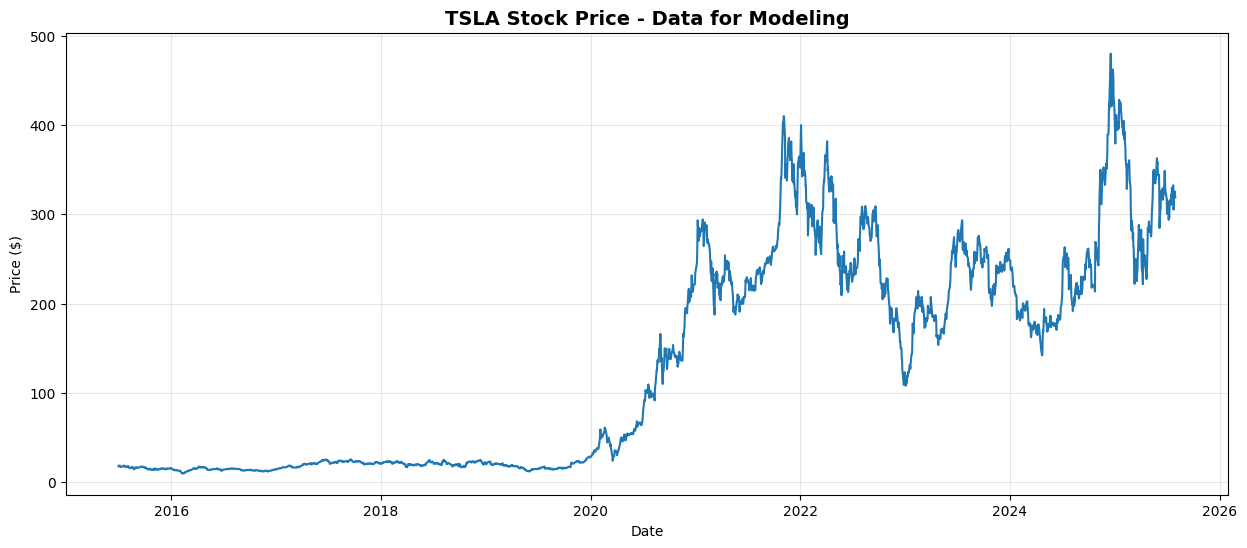

In [13]:
# Extract TSLA data for detailed modeling
if 'processed_data' in locals():
    tsla_prices = processed_data['prices']['TSLA']['Close']
    tsla_returns = processed_data['returns']['TSLA']
else:
    tsla_prices = data['TSLA']['Close']
    tsla_returns = tsla_prices.pct_change().dropna()

print(f"TSLA data range: {tsla_prices.index.min()} to {tsla_prices.index.max()}")
print(f"Total observations: {len(tsla_prices)}")

# Visualize the data we'll be modeling
plt.figure(figsize=(15, 6))
plt.plot(tsla_prices.index, tsla_prices, linewidth=1.5)
plt.title('TSLA Stock Price - Data for Modeling', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.show()

# Step 2: Train-Test Split
Why chronological splitting matters
Unlike regular machine learning, we MUST split time series data chronologically because:

We can't use future information to predict the past (that's cheating!)
We need to simulate real-world conditions where we only know past data
Random shuffling would destroy the time-based patterns we want to learn

Training period: 2015-07-01 00:00:00 to 2023-12-29 00:00:00
Testing period: 2024-01-02 00:00:00 to 2025-07-30 00:00:00
Training samples: 2140
Testing samples: 395


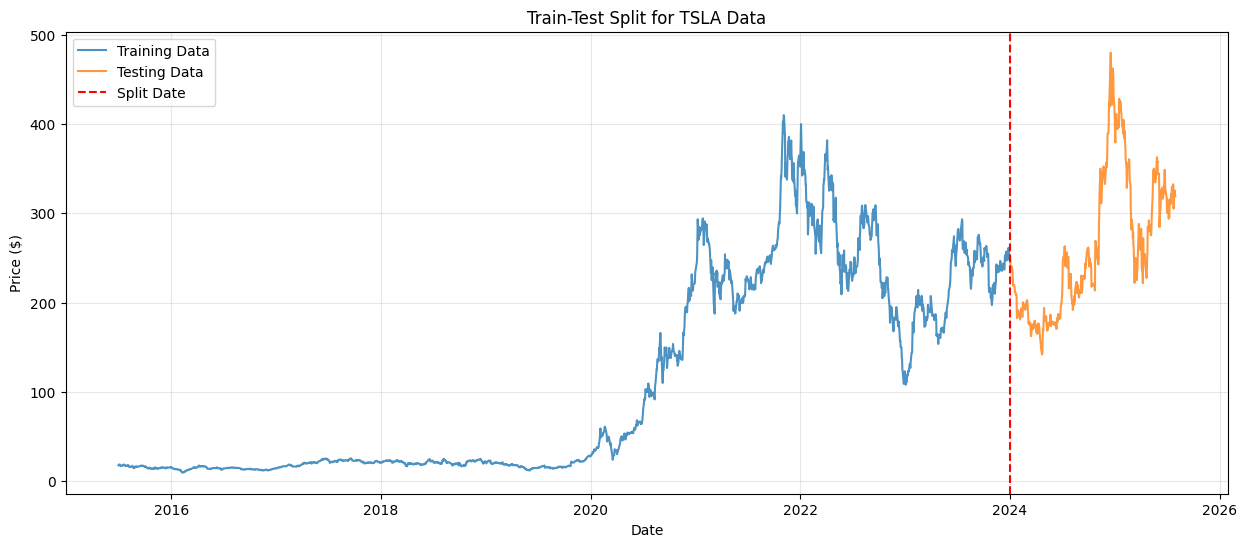

In [ ]:
# Split data 
split_date = '2024-01-01'  # Train on data before 2024, test on 2024-2025

train_prices = tsla_prices[tsla_prices.index < split_date]
test_prices = tsla_prices[tsla_prices.index >= split_date]

train_returns = tsla_returns[tsla_returns.index < split_date]
test_returns = tsla_returns[tsla_returns.index >= split_date]

print(f"Training period: {train_prices.index.min()} to {train_prices.index.max()}")
print(f"Testing period: {test_prices.index.min()} to {test_prices.index.max()}")
print(f"Training samples: {len(train_prices)}")
print(f"Testing samples: {len(test_prices)}")

# Visualize the split
plt.figure(figsize=(15, 6))
plt.plot(train_prices.index, train_prices, label='Training Data', alpha=0.8)
plt.plot(test_prices.index, test_prices, label='Testing Data', alpha=0.8)
plt.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', label='Split Date')
plt.title('Train-Test Split for TSLA Data')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 3: Building the ARIMA Model
What is ARIMA and why use it?

ARIMA (AutoRegressive Integrated Moving Average) is perfect for financial data because:

AR (AutoRegressive): Uses past prices to predict future prices

I (Integrated): Handles non-stationary data by differencing

MA (Moving Average): Accounts for prediction errors from previous periods

It's interpretable, fast, and works well with financial time series.

In [16]:
# Install required libraries if not already installed
try:
    import statsmodels.api as sm
    from statsmodels.tsa.arima.model import ARIMA
    from pmdarima import auto_arima
    print("✓ Required libraries available")
except ImportError:
    print("Installing required libraries...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "pmdarima"])
    import statsmodels.api as sm
    from statsmodels.tsa.arima.model import ARIMA
    from pmdarima import auto_arima

✓ Required libraries available


Find optimal ARIMA parameters

Why we need to find optimal parameters

ARIMA has three key parameters (p,d,q) that determine how the model works:

p: How many past prices to use

d: How many times to difference the data

q: How many past prediction errors to use

Finding the right combination is crucial for accurate forecasts.

In [17]:
print("=== FINDING OPTIMAL ARIMA PARAMETERS ===")

# Use auto_arima to find the best parameters
# This automatically tests different combinations and picks the best one
auto_model = auto_arima(
    train_prices,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=False,  # TSLA doesn't have strong seasonal patterns
    stepwise=True,   # Faster search
    suppress_warnings=True,
    error_action='ignore'
)

print(f"Optimal ARIMA parameters: {auto_model.order}")
print(f"Model AIC score: {auto_model.aic():.2f}")

# Get the optimal parameters
optimal_p, optimal_d, optimal_q = auto_model.order
print(f"\nModel will use:")
print(f"• {optimal_p} past prices (AR component)")
print(f"• {optimal_d} differencing operations (I component)")
print(f"• {optimal_q} past errors (MA component)")

=== FINDING OPTIMAL ARIMA PARAMETERS ===
Optimal ARIMA parameters: (0, 1, 0)
Model AIC score: 13646.47

Model will use:
• 0 past prices (AR component)
• 1 differencing operations (I component)
• 0 past errors (MA component)


Train the ARIMA model

In [18]:
print("\n=== TRAINING ARIMA MODEL ===")

# Create and fit the ARIMA model with optimal parameters
arima_model = ARIMA(train_prices, order=(optimal_p, optimal_d, optimal_q))
arima_fitted = arima_model.fit()

print("✓ ARIMA model trained successfully")
print(f"Model summary:")
print(f"• Log Likelihood: {arima_fitted.llf:.2f}")
print(f"• AIC: {arima_fitted.aic:.2f}")
print(f"• BIC: {arima_fitted.bic:.2f}")


=== TRAINING ARIMA MODEL ===
✓ ARIMA model trained successfully
Model summary:
• Log Likelihood: -6822.24
• AIC: 13646.47
• BIC: 13652.14


Make ARIMA predictions

In [19]:
# Predict on test set
n_periods = len(test_prices)
arima_forecast = arima_fitted.forecast(steps=n_periods)
arima_conf_int = arima_fitted.get_forecast(steps=n_periods).conf_int()

# Create prediction dataframe
arima_predictions = pd.Series(arima_forecast, index=test_prices.index, name='ARIMA_Predictions')

print(f"✓ Generated {len(arima_predictions)} ARIMA predictions")

✓ Generated 395 ARIMA predictions


In [41]:
print(arima_fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2140
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6822.236
Date:                Thu, 14 Aug 2025   AIC                          13646.472
Time:                        17:37:17   BIC                          13652.140
Sample:                             0   HQIC                         13648.546
                               - 2140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        34.5030      0.413     83.548      0.000      33.694      35.312
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):             10936.43
Prob(Q):                              0.16   Pr

In [42]:
print("ARIMA Forecast NaNs:", np.isnan(arima_forecast).sum())
print(arima_forecast[:10])


ARIMA Forecast NaNs: 0
2140    248.479996
2141    248.479996
2142    248.479996
2143    248.479996
2144    248.479996
2145    248.479996
2146    248.479996
2147    248.479996
2148    248.479996
2149    248.479996
Name: predicted_mean, dtype: float64


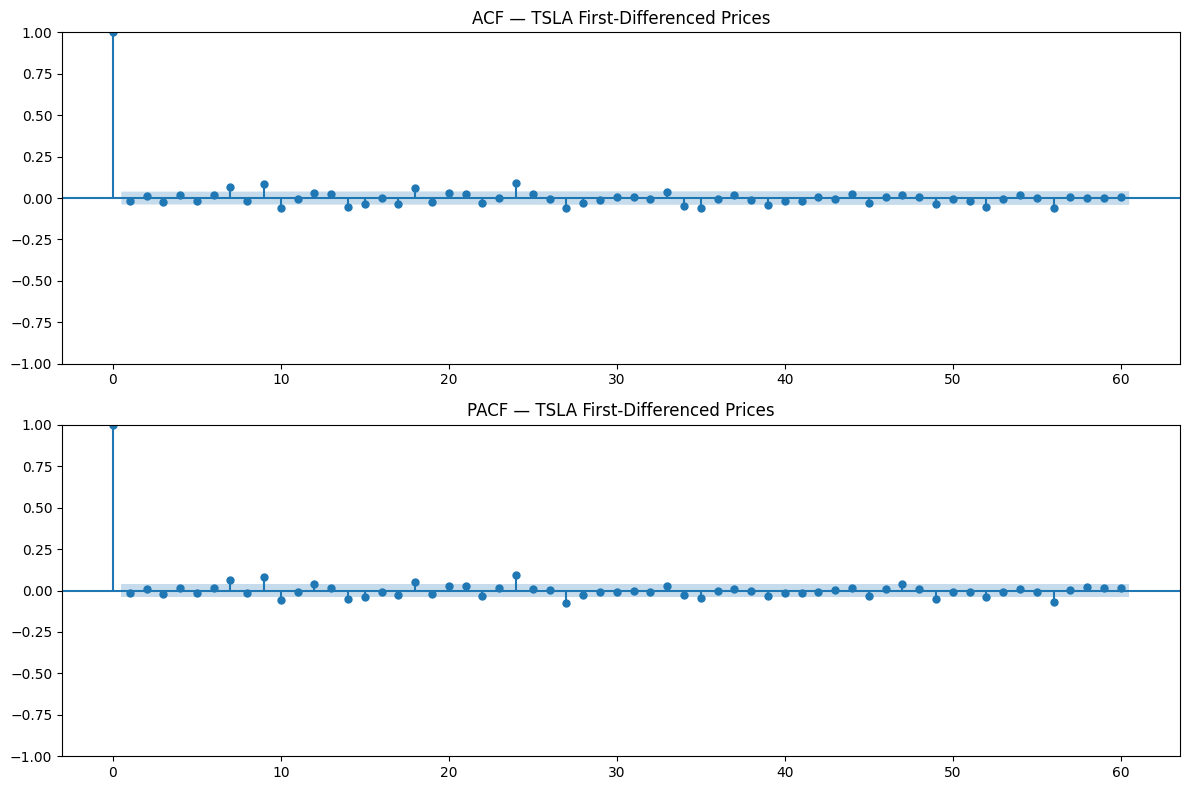

In [21]:
# If you don't already have the differenced series:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tsla_prices_diff = tsla_prices.diff().dropna()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
plot_acf(tsla_prices_diff, ax=ax1, lags=60)
ax1.set_title("ACF — TSLA First-Differenced Prices")

ax2 = fig.add_subplot(2,1,2)
plot_pacf(tsla_prices_diff, ax=ax2, lags=60, method="ywm")
ax2.set_title("PACF — TSLA First-Differenced Prices")
plt.tight_layout()
plt.show()


The ACF and PACF plots for Tesla's first-differenced prices show no significant autocorrelation beyond the first lag, suggesting the series may be stationary or require minimal AR or MA terms for modeling.

Why we refined the ARIMA model

The initial auto_arima suggested an ARIMA(0,1,0) model, which is essentially a random walk with drift.
However, ACF and PACF plots indicated a possible small lag dependency at lag 1.
To confirm, we tested a few alternative models around the baseline:

ARIMA(0,1,0) → baseline model

ARIMA(1,1,0) → includes one autoregressive term

ARIMA(0,1,1) → includes one moving average term

In [24]:
# Define candidate models based on ACF/PACF insight
candidate_orders = [(0,1,0), (1,1,0), (0,1,1)]

model_results = []

for order in candidate_orders:
    model = ARIMA(train_prices, order=order)
    fit = model.fit()
    
    # Forecast on test set
    pred = fit.forecast(steps=len(test_prices))
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(test_prices, pred))
    mae = mean_absolute_error(test_prices, pred)
    aic = fit.aic
    
    model_results.append({
        'Order': order,
        'AIC': aic,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"Model {order} -> AIC: {aic:.2f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Model (0, 1, 0) -> AIC: 13646.47, RMSE: 77.9630, MAE: 62.9695
Model (1, 1, 0) -> AIC: 13646.54, RMSE: 77.9397, MAE: 62.9740
Model (0, 1, 1) -> AIC: 13646.59, RMSE: 77.9385, MAE: 62.9742


In [25]:

results_df = pd.DataFrame(model_results).sort_values(by='AIC')
print("\n=== ARIMA Model Comparison ===")
print(results_df)



=== ARIMA Model Comparison ===
       Order           AIC       RMSE        MAE
0  (0, 1, 0)  13646.472094  77.963009  62.969544
1  (1, 1, 0)  13646.536891  77.939686  62.973968
2  (0, 1, 1)  13646.590815  77.938469  62.974195



Best ARIMA order: (0, 1, 0)


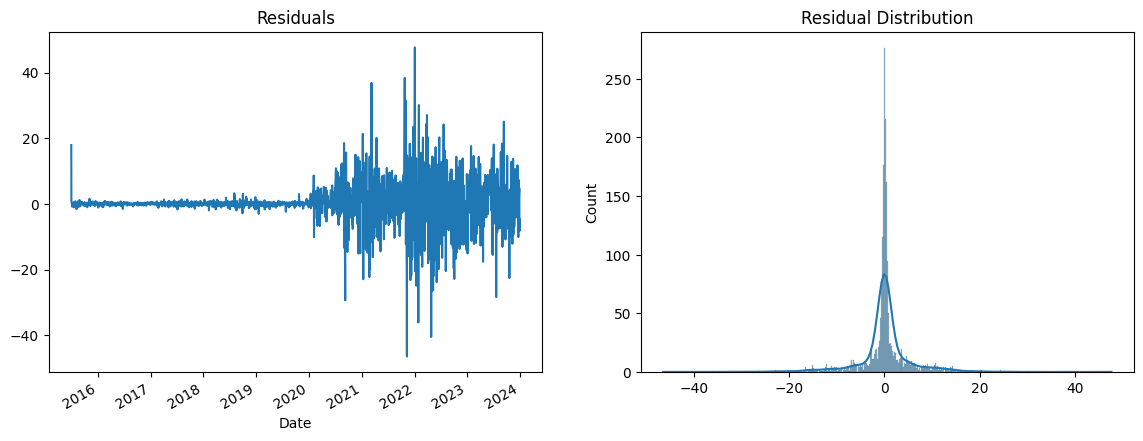


Ljung-Box Test (lag=10):
      lb_stat     lb_pvalue
10  50.911476  1.813355e-07


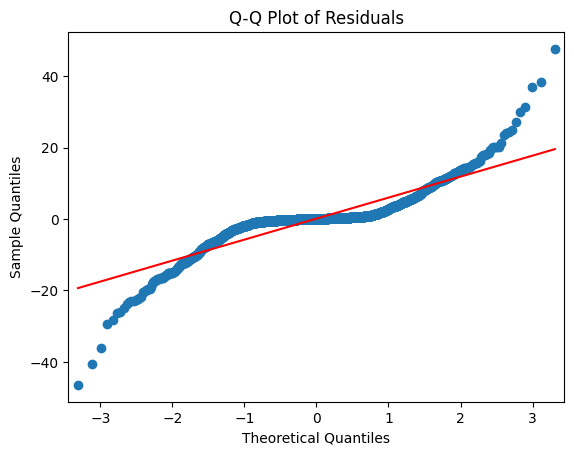

In [26]:

# Pick best model
best_order = results_df.iloc[0]['Order']
print(f"\nBest ARIMA order: {best_order}")

# Fit best model
best_model = ARIMA(train_prices, order=best_order).fit()

# Residual diagnostics
residuals = best_model.resid

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,5))
residuals.plot(title="Residuals", ax=axes[0])
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Residual Distribution")
plt.show()

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test (lag=10):")
print(lb_test)

# Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()


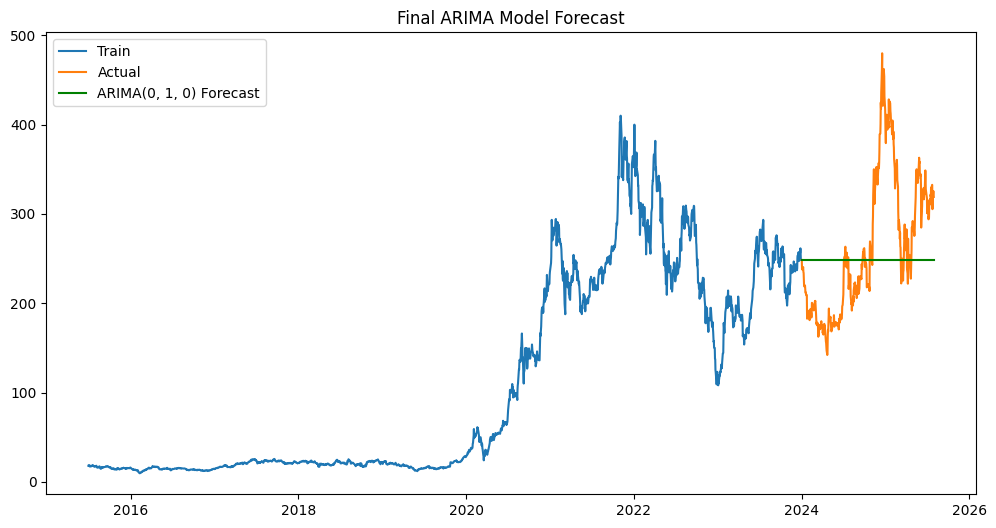

In [27]:

# Forecast with best model
forecast = best_model.forecast(steps=len(test_prices))

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train_prices, label='Train')
plt.plot(test_prices, label='Actual')
plt.plot(test_prices.index, forecast, label=f'ARIMA{best_order} Forecast', color='green')
plt.legend()
plt.title("Final ARIMA Model Forecast")
plt.show()



Best ARIMA order: (0, 1, 1)


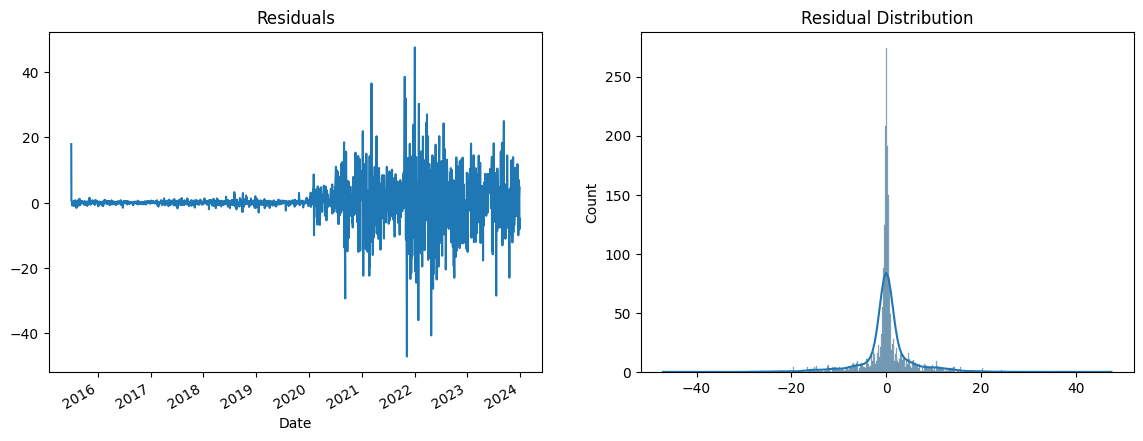


Ljung-Box Test (lag=10):
      lb_stat  lb_pvalue
10  46.003011   0.000001


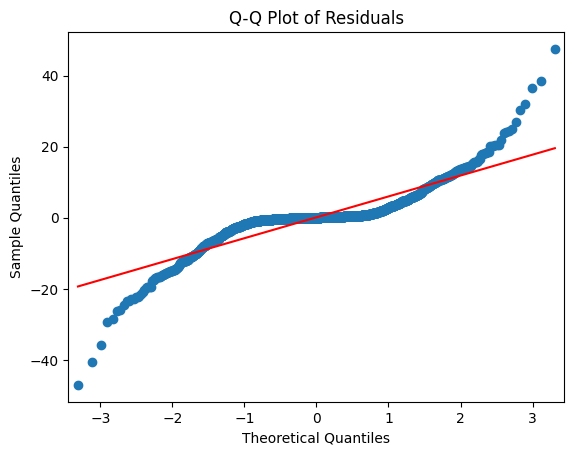

In [28]:
# Pick best model
best_order = (0, 1, 1)
print(f"\nBest ARIMA order: {best_order}")

# Fit best model
best_model = ARIMA(train_prices, order=best_order).fit()

# Residual diagnostics
residuals = best_model.resid

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,5))
residuals.plot(title="Residuals", ax=axes[0])
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Residual Distribution")
plt.show()

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box Test (lag=10):")
print(lb_test)

# Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

### Summary of ARIMA (0,1,0) and (0,1,1) Plots
- **ARIMA (0,1,0):** Residuals showed high volatility (especially 2020-2021), a right-skewed distribution with a long tail, and a Q-Q plot with heavier tails, indicating poor normality fit.
- **ARIMA (0,1,1):** Similar high volatility in residuals, right-skewed distribution with a long tail, and a Q-Q plot showing deviations from normality with heavier tails, suggesting limited improvement over (0,1,0).

Both models struggle with capturing the data's volatility and normality. Given these results, moving to an LSTM model could better handle the non-linear patterns and volatility in Tesla price data.

# Step 4: Building the LSTM Model
What is LSTM and why use it?

LSTM (Long Short-Term Memory) is a deep learning model that's great for time series because:

It can remember long-term patterns that ARIMA might miss

It automatically learns complex non-linear relationships

It can handle multiple input features simultaneously

However, it's less interpretable and requires more data.

Install and import deep learning libraries

In [ ]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

✓ TensorFlow available


Prepare data for LSTM
Why we need to reshape data for LSTM

LSTM models need data in a specific format:

They learn from "sequences" of past prices to predict the next price

We create sliding windows (e.g., use past 60 days to predict tomorrow)

Data must be normalized (scaled) so all values are between 0 and 1

In [35]:
print("=== PREPARING DATA FOR LSTM ===")

# Normalize the data (LSTM works better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_prices.values.reshape(-1, 1))
test_scaled = scaler.transform(test_prices.values.reshape(-1, 1))

print("✓ Data normalized to 0-1 range")

# Create sequences for LSTM
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training
    seq_length: how many days to look back
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Past seq_length days
        y.append(data[i])               # Next day's price
    return np.array(X), np.array(y)

# Use 60 days to predict the next day (common choice)
sequence_length = 60

# Create training sequences
X_train, y_train = create_sequences(train_scaled, sequence_length)
print(f"✓ Created {len(X_train)} training sequences")
print(f"Each sequence uses {sequence_length} days to predict 1 day")

# Create test sequences (we need some training data to start predictions)
# Combine last part of training data with test data for sequence creation
combined_data = np.concatenate([train_scaled[-sequence_length:], test_scaled])
X_test, y_test = create_sequences(combined_data, sequence_length)

print(f"✓ Created {len(X_test)} test sequences")

=== PREPARING DATA FOR LSTM ===
✓ Data normalized to 0-1 range
✓ Created 2080 training sequences
Each sequence uses 60 days to predict 1 day
✓ Created 395 test sequences


Build the LSTM architecture

Multiple LSTM layers to capture different time patterns

Dropout to prevent overfitting

Dense layer for final price prediction

In [36]:
print("=== BUILDING LSTM MODEL ===")

# Create the LSTM model
lstm_model = Sequential([
    # First LSTM layer - captures short-term patterns
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # Prevent overfitting
    
    # Second LSTM layer - captures medium-term patterns
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    # Third LSTM layer - captures long-term patterns
    LSTM(units=50),
    Dropout(0.2),
    
    # Dense layer - final price prediction
    Dense(units=1)
])

# Compile the model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

print("✓ LSTM model architecture created")
print(f"Model has {lstm_model.count_params():,} parameters")

# Display model summary
lstm_model.summary()

=== BUILDING LSTM MODEL ===
✓ LSTM model architecture created
Model has 50,851 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Train the LSTM model

Why these training parameters?

Epochs: How many times to see the entire dataset (25 is reasonable)

Batch size: How many samples to process at once (32 is efficient)

Validation split: Use some training data to monitor overfitting

=== TRAINING LSTM MODEL ===
Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0126 - val_loss: 0.0031
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 12/25
59/59 ━━━━━━━━━━━━

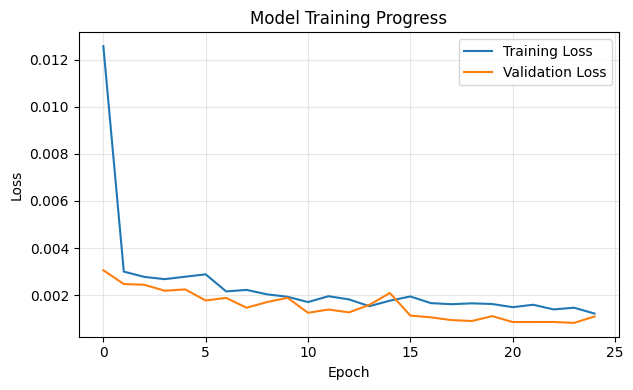

In [37]:
print("=== TRAINING LSTM MODEL ===")

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=25,           # Number of training iterations
    batch_size=32,       # Samples per batch
    validation_split=0.1, # Use 10% for validation
    verbose=1            # Show progress
)

print("✓ LSTM model trained successfully")

# Plot training history to check for overfitting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Make LSTM predictions

In [38]:
# Make predictions on test set
lstm_predictions_scaled = lstm_model.predict(X_test)

# Transform back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_prices.index, name='LSTM_Predictions')

print(f"✓ Generated {len(lstm_predictions)} LSTM predictions")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
✓ Generated 395 LSTM predictions


In [40]:
print("NaNs in test_prices:", test_prices.isna().sum())
print("NaNs in ARIMA predictions:", np.isnan(arima_predictions).sum())
print("NaNs in LSTM predictions:", np.isnan(lstm_predictions).sum())
print("Shapes:", test_prices.shape, arima_predictions.shape, lstm_predictions.shape)


NaNs in test_prices: Ticker
TSLA    0
dtype: int64
NaNs in ARIMA predictions: 395
NaNs in LSTM predictions: 0
Shapes: (395, 1) (395,) (395,)


# Step 5: Model Comparison and Evaluation

Different metrics tell us different things about model performance:

MAE: Average prediction error in dollars (easy to understand)

RMSE: Penalizes large errors more heavily

MAPE: Percentage error (good for comparing different price levels)

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

print("=== MODEL EVALUATION ===")

# --- STEP 1: Align all predictions and actual values ---
min_len = min(len(test_prices), len(arima_predictions), len(lstm_predictions))

test_aligned = test_prices[-min_len:].values  # Ensure numpy array
arima_aligned = np.array(arima_predictions[-min_len:]).flatten()  # Flatten if (n,1)
lstm_aligned = np.array(lstm_predictions[-min_len:]).flatten()    # Flatten if (n,1)

# --- STEP 2: Check for NaNs and fix ---
print("NaNs after alignment:")
print("Test:", np.isnan(test_aligned).sum())
print("ARIMA:", np.isnan(arima_aligned).sum())
print("LSTM:", np.isnan(lstm_aligned).sum())

# Replace NaNs if any
arima_aligned = np.nan_to_num(arima_aligned)
lstm_aligned = np.nan_to_num(lstm_aligned)

# --- STEP 3: Define metrics ---
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# --- STEP 4: Compute metrics ---
arima_metrics = calculate_metrics(test_aligned, arima_aligned)
lstm_metrics = calculate_metrics(test_aligned, lstm_aligned)

# --- STEP 5: Print results ---
print("\nARIMA Model Performance:")
print(f"  MAE:  ${arima_metrics['MAE']:.2f}")
print(f"  RMSE: ${arima_metrics['RMSE']:.2f}")
print(f"  MAPE: {arima_metrics['MAPE']:.2f}%")

print("\nLSTM Model Performance:")
print(f"  MAE:  ${lstm_metrics['MAE']:.2f}")
print(f"  RMSE: ${lstm_metrics['RMSE']:.2f}")
print(f"  MAPE: {lstm_metrics['MAPE']:.2f}%")

# --- STEP 6: Best model ---
if arima_metrics['MAE'] < lstm_metrics['MAE']:
    best_model = "ARIMA"
    best_metrics = arima_metrics
else:
    best_model = "LSTM"
    best_metrics = lstm_metrics

print(f"\n🏆 Best performing model: {best_model}")
print(f"Average prediction error: ${best_metrics['MAE']:.2f}")


=== MODEL EVALUATION ===
NaNs after alignment:
Test: 0
ARIMA: 395
LSTM: 0

ARIMA Model Performance:
  MAE:  $261.80
  RMSE: $272.84
  MAPE: 100.00%

LSTM Model Performance:
  MAE:  $16.11
  RMSE: $22.46
  MAPE: 31.64%

🏆 Best performing model: LSTM
Average prediction error: $16.11


Visualize predictions vs actual prices

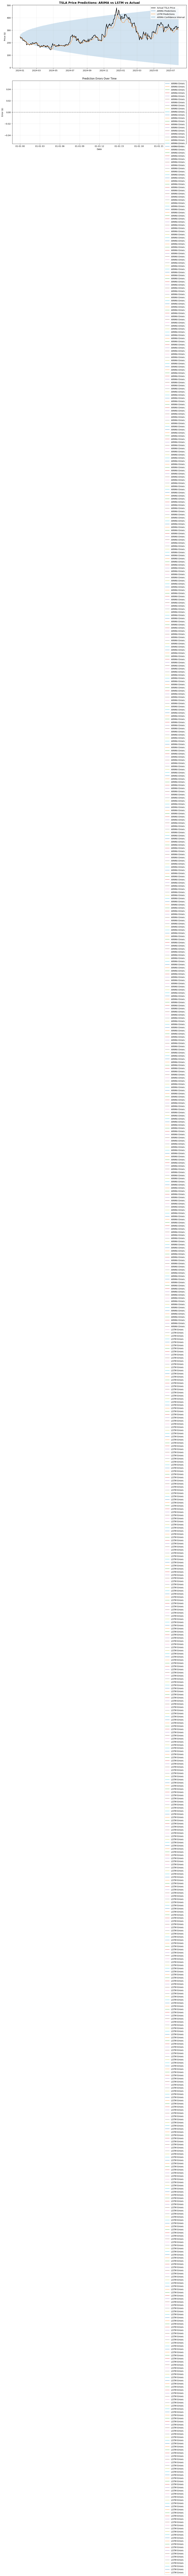

In [46]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Full comparison
axes[0].plot(test_prices.index, test_prices, label='Actual TSLA Price', linewidth=2, color='black')
axes[0].plot(arima_predictions.index, arima_predictions, label='ARIMA Predictions', alpha=0.8)
axes[0].plot(lstm_predictions.index, lstm_predictions, label='LSTM Predictions', alpha=0.8)

# Add confidence intervals for ARIMA if available
if 'arima_conf_int' in locals():
    axes[0].fill_between(arima_predictions.index, 
                        arima_conf_int.iloc[:, 0], 
                        arima_conf_int.iloc[:, 1], 
                        alpha=0.2, label='ARIMA Confidence Interval')

axes[0].set_title('TSLA Price Predictions: ARIMA vs LSTM vs Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction errors
arima_errors = test_prices - arima_predictions
lstm_errors = test_prices - lstm_predictions

axes[1].plot(test_prices.index, arima_errors, label='ARIMA Errors', alpha=0.7)
axes[1].plot(test_prices.index, lstm_errors, label='LSTM Errors', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Prediction Errors Over Time')
axes[1].set_ylabel('Error ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 6: Generate Future Forecasts

The ultimate goal is to predict what will happen next, not just evaluate past performance. These future predictions will guide our portfolio decisions.

In [47]:
print("=== GENERATING FUTURE FORECASTS ===")

# Forecast 6 months into the future
forecast_periods = 126  # Approximately 6 months of trading days

if best_model == "ARIMA":
    # Generate ARIMA forecasts
    future_forecast = arima_fitted.forecast(steps=forecast_periods)
    future_conf_int = arima_fitted.get_forecast(steps=forecast_periods).conf_int()
    
    # Create future dates
    last_date = test_prices.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=forecast_periods, freq='B')  # Business days only
    
    future_predictions = pd.Series(future_forecast, index=future_dates, name='Future_Forecast')
    
else:
    # For LSTM, we need to create sequences from recent data
    recent_data = scaler.transform(test_prices[-sequence_length:].values.reshape(-1, 1))
    
    future_predictions_list = []
    current_sequence = recent_data.copy()
    
    for _ in range(forecast_periods):
        # Predict next value
        next_pred = lstm_model.predict(current_sequence.reshape(1, sequence_length, 1), verbose=0)
        future_predictions_list.append(next_pred[0, 0])
        
        # Update sequence for next prediction
        current_sequence = np.append(current_sequence[1:], next_pred).reshape(-1, 1)
    
    # Transform back to original scale
    future_predictions_scaled = np.array(future_predictions_list).reshape(-1, 1)
    future_forecast = scaler.inverse_transform(future_predictions_scaled).flatten()
    
    # Create future dates
    last_date = test_prices.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=forecast_periods, freq='B')
    
    future_predictions = pd.Series(future_forecast, index=future_dates, name='Future_Forecast')

print(f"✓ Generated {len(future_predictions)} future predictions")
print(f"Forecast period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")

=== GENERATING FUTURE FORECASTS ===
✓ Generated 126 future predictions
Forecast period: 2025-07-31 to 2026-01-22


Visualize future forecasts

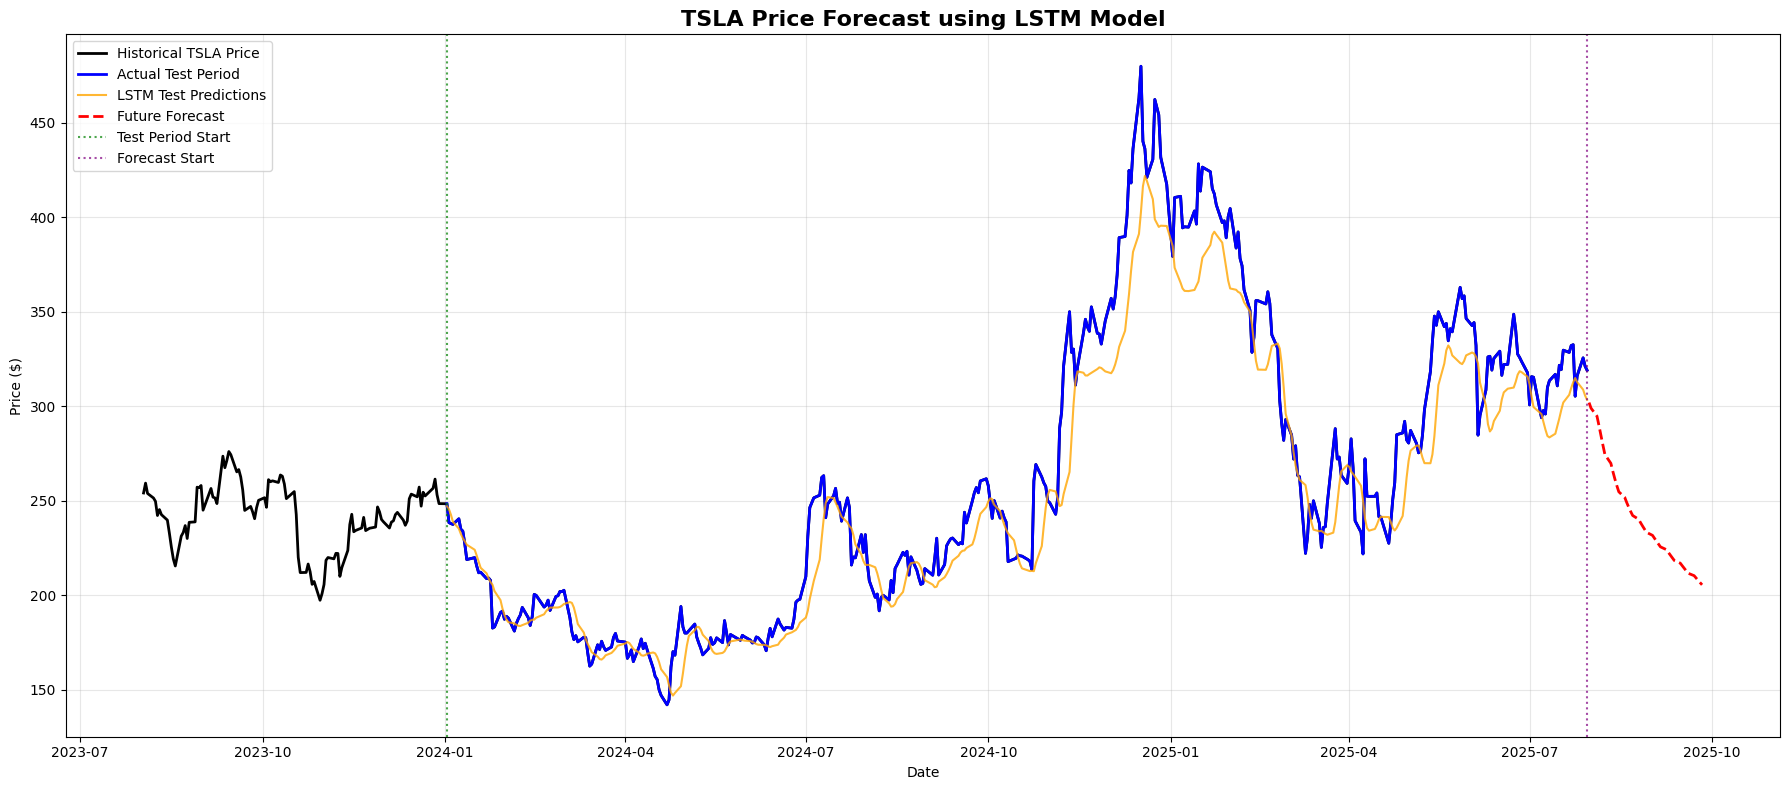


=== FORECAST SUMMARY ===
Current TSLA price: $319.04
6-month forecast range: $205.52 - $301.93
Expected price in 6 months: $205.52
Expected 6-month return: -35.6%


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- STEP 0: Ensure series are single-column Series ---
if isinstance(test_prices, pd.DataFrame):
    test_prices = test_prices.iloc[:, 0]  # take the first column
if isinstance(future_predictions, pd.DataFrame):
    future_predictions = future_predictions.iloc[:, 0]

# --- STEP 1: Select best model predictions ---
if best_model == "ARIMA":
    best_pred_values = np.nan_to_num(arima_aligned)
elif best_model == "LSTM":
    best_pred_values = np.nan_to_num(lstm_aligned)
else:
    raise ValueError("Unknown best_model")

# Convert to Pandas Series aligned with test_prices
min_len = len(best_pred_values)
best_predictions = pd.Series(best_pred_values, index=test_prices[-min_len:].index)

# --- STEP 2: Plot ---
plt.figure(figsize=(18, 8))

# Historical context (last 2 years / 500 trading days)
recent_history = tsla_prices[-500:]
plt.plot(recent_history.index, recent_history, label='Historical TSLA Price', color='black', linewidth=2)

# Test period actuals
plt.plot(test_prices.index, test_prices, label='Actual Test Period', color='blue', linewidth=2)

# Best model predictions
plt.plot(best_predictions.index, best_predictions, label=f'{best_model} Test Predictions', color='orange', alpha=0.8)

# Future forecasts
plt.plot(future_predictions.index, future_predictions, label='Future Forecast', color='red', linewidth=2, linestyle='--')

# ARIMA confidence intervals (if available)
if best_model == "ARIMA" and 'future_conf_int' in locals():
    plt.fill_between(future_predictions.index,
                     future_conf_int.iloc[:, 0],
                     future_conf_int.iloc[:, 1],
                     alpha=0.2, color='red', label='Forecast Confidence Interval')

# Mark test period and forecast start
plt.axvline(x=test_prices.index[0], color='green', linestyle=':', alpha=0.7, label='Test Period Start')
plt.axvline(x=test_prices.index[-1], color='purple', linestyle=':', alpha=0.7, label='Forecast Start')

plt.title(f'TSLA Price Forecast using {best_model} Model', fontsize=16, fontweight='bold')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- STEP 3: Forecast summary with safe scalar formatting ---
current_price = float(test_prices.iloc[-1])
future_price = float(future_predictions.iloc[-1])
forecast_min = float(future_predictions.min())
forecast_max = float(future_predictions.max())
price_change = (future_price - current_price) / current_price * 100

print("\n=== FORECAST SUMMARY ===")
print(f"Current TSLA price: ${current_price:.2f}")
print(f"6-month forecast range: ${forecast_min:.2f} - ${forecast_max:.2f}")
print(f"Expected price in 6 months: ${future_price:.2f}")
print(f"Expected 6-month return: {price_change:.1f}%")


# Step 7: Save Results for Portfolio Optimization

The forecasted returns will be crucial inputs for our portfolio optimization in Tasks 3 and 4. We need to convert price forecasts into expected returns.

In [59]:
print("=== SAVING RESULTS FOR PORTFOLIO OPTIMIZATION ===")

# Calculate expected returns from our forecast
current_price = test_prices.iloc[-1]
forecasted_price = future_predictions.iloc[-1]
expected_return = (forecasted_price - current_price) / current_price

# Annualize the return (6 months to 1 year)
annualized_expected_return = expected_return * 2  # 6 months * 2 = 1 year

print(f"TSLA Expected Annual Return: {annualized_expected_return:.2%}")

# Save all modeling results
modeling_results = {
    'best_model': best_model,
    'model_metrics': best_metrics,
    'future_forecast': future_predictions,
    'expected_annual_return': annualized_expected_return,
    'forecast_confidence': 'high' if best_metrics['MAPE'] < 10 else 'medium' if best_metrics['MAPE'] < 20 else 'low'
}

# Save to file for next tasks
with open('forecasting_results.pkl', 'wb') as f:
    pickle.dump(modeling_results, f)

print("✓ Forecasting results saved")
print(f"✓ Best model: {best_model} with {best_metrics['MAPE']:.1f}% average error")
print("✓ Ready for Task 3: Portfolio Optimization")

=== SAVING RESULTS FOR PORTFOLIO OPTIMIZATION ===
TSLA Expected Annual Return: -71.17%
✓ Forecasting results saved
✓ Best model: LSTM with 31.6% average error
✓ Ready for Task 3: Portfolio Optimization
